In [ ]:
import pandas as pd
import numpy as np
import os
from env import user, host, password

In [18]:
import pandas as pd
import numpy as np
import os
from env import user, host, password
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

#**************************************************Acquire*******************************************************


def get_connection(db, username=user, host=host, password=password):
    '''
    Creates a connection URL
    '''
    return f'mysql+pymysql://{username}:{password}@{host}/{db}'
    

    
    
def new_zillow_data():
    '''
    Returns zillow data as a dataframe
    '''
    sql_query = '''SELECT
                    bedroomcnt,
                    bathroomcnt, 
                    calculatedfinishedsquarefeet,
                    taxvaluedollarcnt,
                    yearbuilt,
                    taxamount,
                    fips
                    FROM properties_2017
                    join propertylandusetype using(propertylandusetypeid)
                    where propertylandusetypeid = 261'''
    df = pd.read_sql(sql_query, get_connection('zillow'))
    return df 




def get_zillow_data():
    '''get connection, returns Zillow into a dataframe and creates a csv for us'''
    if os.path.isfile('zillow.csv'):
        df = pd.read_csv('zillow.csv', index_col=0)
    else:
        df = new_zillow_data()
        df.to_csv('zillow.csv')
    return df



#**************************************************Remove Outliers*******************************************************

def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

#**************************************************Distributions*******************************************************

def get_hist(df):
    ''' Gets histographs of acquired continuous variables'''
    
    plt.figure(figsize=(16, 3))

    # List of columns
    cols = [col for col in df.columns if col not in ['fips', 'yearbuilt']]

    for i, col in enumerate(cols):

        # i starts at 0, but plot nos should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display histogram for column.
        df[col].hist(bins=5)

        # Hide gridlines.
        plt.grid(False)

        # turn off scientific notation
        plt.ticklabel_format(useOffset=False)

        plt.tight_layout()

    plt.show()
        
        
def get_box(df):
    ''' Gets boxplots of acquired continuous variables'''
    
    # List of columns
    cols = ['bedrooms', 'bathrooms', 'sqft', 'taxvalue', 'taxamount']

    plt.figure(figsize=(16, 3))

    for i, col in enumerate(cols):

        # i starts at 0, but plot should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display boxplot for column.
        sns.boxplot(data=df[[col]])

        # Hide gridlines.
        plt.grid(False)

        # sets proper spacing between plots
        plt.tight_layout()

    plt.show()

#**************************************************Prepare*******************************************************

def prepare_zillow():
    '''acquires and prepares the zillow data for us. Drops all null values (.005% of the data) then drops all 
    outliers'''
    # Get zillow file
    df = get_zillow_data()
    # Drop the null in every column(less than .006% of the data)
    df = df.dropna()
    # Remove the outliers
    k=1.5
    col_list=df.columns
    df = remove_outliers(df, k, col_list)
    # reset index
    df.reset_index(inplace=True,drop=True)
    # rename my columns
    df = df.rename(columns={"bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "calculatedfinishedsquarefeet": "sqft", "taxvaluedollarcnt": "taxvalue"})
    # converts float whole numbers to int
    slc =['bedrooms','sqft','taxvalue','yearbuilt','fips']
    df[slc] = df[slc].astype(int)
    # converting column data thats categorical into objects so that tgey wont be used in mathmetics
    df.fips = df.fips.astype(object)
    df.year_built = df.yearbuilt.astype(object)
    # get distributions of numeric data
    get_hist(df)
    get_box(df)
    # train/validate/test split
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    return train, validate, test 
#**************************************************Wrangle*******************************************************


def wrangle_zillow():
    '''Acquire and prepare data from Zillow database for explore'''
    train, validate, test = prepare_zillow()
    
    return train, validate, test

/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
<ipython-input-18-f03b771fc0b0>:162: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.year_built = df.yearbuilt.astype(object)


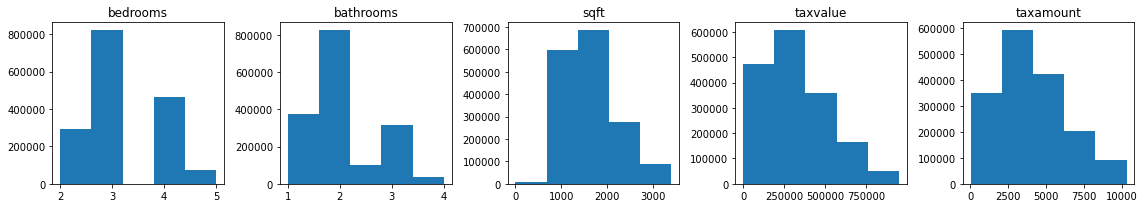

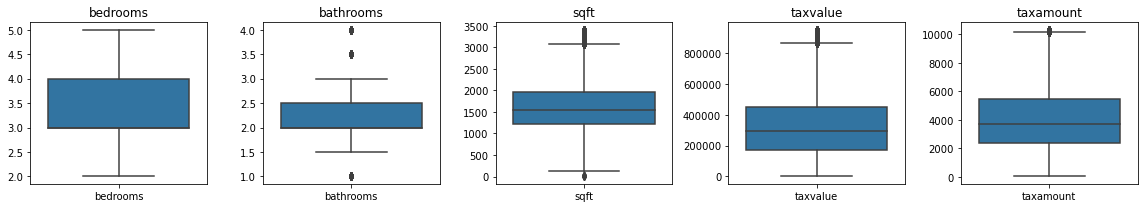

In [19]:
train, validate, test = wrangle_zillow() 

In [16]:
train

,bedrooms,bathrooms,sqft,taxvalue,yearbuilt,taxamount,fips
1878634,4,2.0,1914,85004,1967,1391.00,6059
1995330,5,3.0,2110,164459,1973,2680.47,6037
1501358,2,1.5,1417,543691,1952,5964.70,6059
391891,4,3.0,2580,954550,1986,11350.33,6037
1958267,3,1.0,1144,256937,1957,3469.52,6037
...,...,...,...,...,...,...,...
412463,2,2.0,976,690000,1938,8244.57,6037
23107,3,2.0,1839,102676,1968,1667.13,6037
107490,3,1.0,1021,440000,1944,5181.33,6037
1626782,4,2.0,1670,330442,1948,4078.81,6037


In [17]:
train.head()

,bedrooms,bathrooms,sqft,taxvalue,yearbuilt,taxamount,fips
1878634,4,2.0,1914,85004,1967,1391.00,6059
1995330,5,3.0,2110,164459,1973,2680.47,6037
1501358,2,1.5,1417,543691,1952,5964.70,6059
391891,4,3.0,2580,954550,1986,11350.33,6037
1958267,3,1.0,1144,256937,1957,3469.52,6037


In [ ]:
df.info()

In [ ]:
df.isnull().sum()

In [ ]:
df.bedroomcnt.value_counts()

In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

In [ ]:
df.shape

In [ ]:
### fill the bedroom count nulls with the mode(which is 3)
df.bathroomcnt = df.bathroomcnt.fillna(value= df.bathroomcnt.mode()[0])

In [ ]:
df.bathroomcnt.mode()

In [ ]:
df.bathroomcnt.value_counts()

In [ ]:
k=3
col_list=df.columns

In [ ]:
remove_outliers(df, k, col_list)

In [ ]:
df=wrangle_zillow()


In [ ]:
df.info()

In [ ]:
 df = df.rename(columns={"bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "calculatedfinishedsquarefeet": "sqft", "taxvaluedollarcnt": "taxvalue"})
    slc =['bedrooms','sqft','taxvalue','yearbuilt','fips']
    df[slc] = df[slc].astype(int)

In [ ]:
df.bedrooms.apply(float.is_integer).all()